In [2]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.io import read_image
from torchsummary import summary

from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

device = "cpu"
if torch.cuda.is_available():
    device="cuda"

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.info = df
        self.transform = transform

    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        path = self.info.imgPath.values[idx]
        label = self.info['class'].values[idx]
        image = read_image(path, mode=torchvision.io.image.ImageReadMode.RGB).float()

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
df= pd.read_csv("breastCancerDataframe.csv", index_col=0)
print(df.head())

patientIDs = df.patient.unique()
print("Number of Unique Patients: ", len(patientIDs))

patients_train, temp = train_test_split(patientIDs, test_size=0.3, random_state=42)
patients_val, patients_test = train_test_split(temp, test_size=0.5, random_state=42)

df_train = df.loc[df['patient'].isin(patients_train)]
print(df_train.head())
print("Number of Train Patients: ", df_train.patient.nunique())

df_val = df.loc[df['patient'].isin(patients_val)]
print(df_val.head())
print("Number of Validation Patients: ", df_val.patient.nunique())

df_test = df.loc[df['patient'].isin(patients_test)]
print(df_test.head())
print("Number of Test Patients: ", df_test.patient.nunique())

   patient  class  posX  posY                                         imgPath
0    12954      0  1151  1401  data/12954/0/12954_idx5_x1151_y1401_class0.png
1    12954      0  1951  2901  data/12954/0/12954_idx5_x1951_y2901_class0.png
2    12954      0   151   501    data/12954/0/12954_idx5_x151_y501_class0.png
3    12954      0  1701  2251  data/12954/0/12954_idx5_x1701_y2251_class0.png
4    12954      0  1501  2001  data/12954/0/12954_idx5_x1501_y2001_class0.png
Number of Unique Patients:  279
   patient  class  posX  posY                                         imgPath
0    12954      0  1151  1401  data/12954/0/12954_idx5_x1151_y1401_class0.png
1    12954      0  1951  2901  data/12954/0/12954_idx5_x1951_y2901_class0.png
2    12954      0   151   501    data/12954/0/12954_idx5_x151_y501_class0.png
3    12954      0  1701  2251  data/12954/0/12954_idx5_x1701_y2251_class0.png
4    12954      0  1501  2001  data/12954/0/12954_idx5_x1501_y2001_class0.png
Number of Train Patients:  195
 

In [5]:
BATCH_SIZE = 128

transform = transforms.Compose([
        #transforms.RandomRotation(45),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = CustomImageDataset(df_train, transform=transform)
val_dataset = CustomImageDataset(df_val, transform=transform)
test_dataset = CustomImageDataset(df_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [48]:
"""
model=models.resnet18(pretrained=True)
print(model)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, 1))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
"""

'\nmodel=models.resnet18(pretrained=True)\nprint(model)\n\nmodel.fc = nn.Sequential(\n    nn.Linear(model.fc.in_features, 512),\n    nn.ReLU(),\n    nn.BatchNorm1d(512),\n    nn.Dropout(0.5),\n\n    nn.Linear(512, 256),\n    nn.ReLU(),\n    nn.BatchNorm1d(256),\n    nn.Dropout(0.5),\n\n    nn.Linear(256, 1))\n\ndef init_weights(m):\n    if type(m) == nn.Linear:\n        torch.nn.init.xavier_uniform_(m.weight)\n        m.bias.data.fill_(0.01)\n\nmodel.apply(init_weights)\n'

In [6]:
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),

    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Linear(256, 1))

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
#summary(model, (3,224,224))

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [7]:
# Calculate performance measures
def compute_performance(yhat, y, pos_cutoff):

    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat >= pos_cutoff, y == 1).numpy())
    tn = sum(np.logical_and(yhat < pos_cutoff, y == 0).numpy())
    fp = sum(np.logical_and(yhat >= pos_cutoff, y == 0).numpy())
    fn = sum(np.logical_and(yhat < pos_cutoff, y == 1).numpy())

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")

    # Accuracy
    #acc = (tp + tn) / (tp + tn + fp + fn)

    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)

    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)

    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall

    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)

    balanced_acc = 0.5*(sensitivity+specificity)
    #fMeasure =  2*((precision*recall)/(precision+recall))

    auroc = roc_auc_score(y, yhat)

    # Print results
    print("Balanced Accuracy: ", balanced_acc," Specificity: ",specificity," AUROC Score: ", auroc,
          " Sensitivity: ",sensitivity," Precision: ",precision,)

def train(model, dataloader_train, dataloader_val, device='cpu', epochs=10, early_stop=2, lr=0.001, verbose=True):

    opt = torch.optim.Adam(model.classifier.parameters(), lr=lr)
    #opt = torch.optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    model.to(device)

    lowest_val_loss, train_loss = np.inf, 0
    lowest_val_epoch = 0
    epochs_wo_improvement = 0
    best_model = copy.deepcopy(model.state_dict())
    train_losses, val_losses=[], []

    for e in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()

        for inputs, targets in tqdm(dataloader_train):

            inputs, targets = inputs.to(device), targets.to(device)

            model.zero_grad(set_to_none=True)

            output = model.forward(inputs)
            loss = criterion(output.squeeze(), targets.float())
            loss.backward()
            opt.step()

            epoch_train_loss+=loss

        epoch_train_loss = epoch_train_loss.item()/((len(dataloader_train.dataset)%BATCH_SIZE)*BATCH_SIZE)

        train_losses.append(epoch_train_loss)

        #VALIDATION

        model.eval()
        val_preds, val_targets_list = [], []

        with torch.no_grad():
            for val_inputs, val_targets in tqdm(dataloader_val):

                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                model.zero_grad(set_to_none=True)

                val_output = model.forward(val_inputs).squeeze()
                val_preds+=val_output
                val_targets_list+=val_targets

                epoch_val_loss += criterion(val_output, val_targets.float())

            epoch_val_loss = epoch_val_loss.item()/((len(dataloader_val.dataset)%BATCH_SIZE)*BATCH_SIZE)
            val_losses.append(epoch_val_loss)

            compute_performance(torch.sigmoid(torch.Tensor(val_preds)), torch.Tensor(val_targets_list), 0.5)

        if epoch_val_loss <= lowest_val_loss:
            best_model = copy.deepcopy(model.state_dict())
            lowest_val_loss = epoch_val_loss
            train_loss=epoch_train_loss
            lowest_val_epoch=e
            epochs_wo_improvement=0
        else:
            epochs_wo_improvement+=1

        if verbose:
            print("Epoch: {}/{}...".format(e, epochs), "Loss: {:.4f}...".format(epoch_train_loss), "Val Loss: {:.4f}".format(epoch_val_loss),)

        #early stopping
        if epochs_wo_improvement>=early_stop:
            if verbose:
                print("Early Stop no improvement in validation loss in "+str(early_stop)+" validation steps")
            break

    if verbose:
        print("\nLowest Validation Loss: "+str(lowest_val_loss)+" at epoch "+str(lowest_val_epoch)+'\n')

    model.load_state_dict(best_model)

    run_ID = datetime.now().strftime("%Y-%m-%d_%H-%M")
    torch.save({'model_state_dict': best_model}, './BestModels/'+str(run_ID)+'_E_'+str(lowest_val_epoch)+'_TL_'+str(round(train_loss, 4))+'_VL_'+str(round(lowest_val_loss, 4))+'.pt')

    model.to("cpu")
    torch.cuda.empty_cache()

    return model, train_losses, val_losses

In [15]:
torch.backends.cudnn.benchmark = True
model, train_losses, val_losses = train(model, train_dataloader, val_dataloader, device=device)

  0%|          | 0/1534 [00:00<?, ?it/s]

tp: 10620 tn: 26714 fp: 1860 fn: 3506
Balanced Accuracy:  0.8433555202033799  Specificity:  0.9349058584727374  Sensitivity:  0.7518051819340223  Precision:  0.8509615384615384
Epoch: 0/10... Loss: 0.3739... Val Loss: 0.0101


  0%|          | 0/1534 [00:00<?, ?it/s]

tp: 10447 tn: 26987 fp: 1587 fn: 3679
Balanced Accuracy:  0.8420091299810768  Specificity:  0.944459998600126  Sensitivity:  0.7395582613620275  Precision:  0.8681236496592987
Epoch: 1/10... Loss: 0.3447... Val Loss: 0.0103


  0%|          | 0/1534 [00:00<?, ?it/s]

tp: 10587 tn: 26871 fp: 1703 fn: 3539
Balanced Accuracy:  0.8449347140521476  Specificity:  0.9404003639672429  Sensitivity:  0.7494690641370523  Precision:  0.8614320585842148
Epoch: 2/10... Loss: 0.3353... Val Loss: 0.0101


  0%|          | 0/1534 [00:00<?, ?it/s]

tp: 9979 tn: 27240 fp: 1334 fn: 4147
Balanced Accuracy:  0.8298710326179662  Specificity:  0.953314201721845  Sensitivity:  0.7064278635140875  Precision:  0.8820825598868558
Epoch: 3/10... Loss: 0.3291... Val Loss: 0.0104


  0%|          | 0/301 [00:00<?, ?it/s]

tp: 10139 tn: 27122 fp: 1452 fn: 3987
Balanced Accuracy:  0.833469534322684  Specificity:  0.949184573388395  Sensitivity:  0.717754495256973  Precision:  0.8747303942714175
Epoch: 4/10... Loss: 0.3241... Val Loss: 0.0104
Early Stop no improvement in validation loss in 2 validation steps

Lowest Validation Loss: 0.010067480175118697 at epoch 2



  0%|          | 0/301 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [22]:
model.to(device)
model.eval()
test_preds, test_targets_list = [], []
test_loss = 0

with torch.no_grad():
    criterion = nn.BCEWithLogitsLoss()

    for test_inputs, test_targets in tqdm(test_dataloader):

        test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)

        model.zero_grad(set_to_none=True)

        test_output = model.forward(test_inputs).squeeze()
        test_preds+=test_output
        test_targets_list+=test_targets

        test_loss += criterion(test_output, test_targets.float())

    print("Test Loss: ", test_loss.item()/((len(test_dataloader.dataset)%BATCH_SIZE)*BATCH_SIZE))

    compute_performance(torch.sigmoid(torch.Tensor(test_preds)), torch.Tensor(test_targets_list), 0.5)

100%|██████████| 301/301 [01:09<00:00,  4.31it/s]


Test Loss:  0.010843710553261542
tp: 8854 tn: 24952 fp: 2483 fn: 2239
Balanced Accuracy:  0.8538280864183687  Specificity:  0.9094951704027702  Sensitivity:  0.7981610024339674  Precision:  0.7809826232689424


Percent Neg:  0.7270911259007103
Percent Pos:  0.2729088740992896
Neg Count:  142680 Pos Count:  53554

Class Percentages After Splitting
Percent Neg Train1:  0.47036018751112607 Percent Pos Train 1:  0.5296398124888739
Percent Neg Train2:  0.47036018751112607 Percent Pos Train 2:  0.5296398124888739
Percent Neg Train3:  0.47036018751112607 Percent Pos Train 3:  0.5296398124888739


c:\users\spencer\documents\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\spencer\documents\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\spencer\documents\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

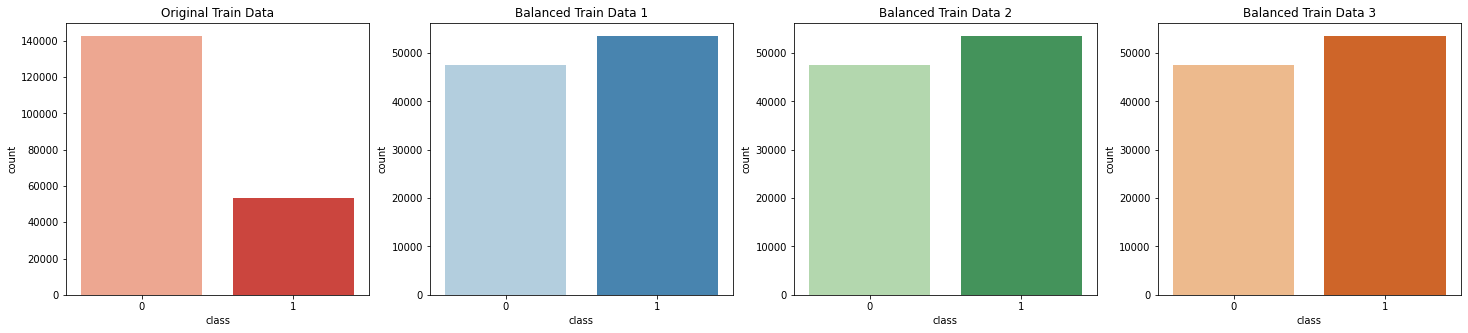

In [8]:
print("Percent Neg: ", (df_train['class'].to_list()).count(0)/len(df_train))
print("Percent Pos: ", (df_train['class'].to_list()).count(1)/len(df_train))

df_train_neg = df_train.loc[df_train['class']==0]
df_train_pos = df_train.loc[df_train['class']==1]
print("Neg Count: ", len(df_train_neg), "Pos Count: ",len(df_train_pos))

#split it into 3 since i would rater the model have an over represented positive class so the model
#predicts pos more than neg since identifying pos is more important
df_train1, temp = train_test_split(df_train_neg, train_size=1/3, random_state=42)
df_train2, df_train3 = train_test_split(temp, train_size=1/2, random_state=42)
df_train1 = pd.concat([df_train1, df_train_pos], ignore_index=True)
df_train2 = pd.concat([df_train2, df_train_pos], ignore_index=True)
df_train3 = pd.concat([df_train3, df_train_pos], ignore_index=True)


fig, ax = plt.subplots(1,4,figsize=(25,5))
sns.countplot(df_train['class'], ax=ax[0], palette="Reds")
ax[0].set_title("Original Train Data")
sns.countplot(df_train1['class'], ax=ax[1], palette="Blues")
ax[1].set_title("Balanced Train Data 1")
sns.countplot(df_train2['class'], ax=ax[2], palette="Greens")
ax[2].set_title("Balanced Train Data 2")
sns.countplot(df_train3['class'], ax=ax[3], palette="Oranges")
ax[3].set_title("Balanced Train Data 3")

print("\nClass Percentages After Splitting")
print("Percent Neg Train1: ", (df_train1['class'].to_list()).count(0)/len(df_train1), "Percent Pos Train 1: ", (df_train1['class'].to_list()).count(1)/len(df_train1))
print("Percent Neg Train2: ", (df_train2['class'].to_list()).count(0)/len(df_train2), "Percent Pos Train 2: ", (df_train2['class'].to_list()).count(1)/len(df_train2))
print("Percent Neg Train3: ", (df_train3['class'].to_list()).count(0)/len(df_train3), "Percent Pos Train 3: ", (df_train3['class'].to_list()).count(1)/len(df_train3))

train_dataloaders = [DataLoader(CustomImageDataset(df_train1, transform=transform), batch_size=BATCH_SIZE, shuffle=True), DataLoader(CustomImageDataset(df_train2, transform=transform), batch_size=BATCH_SIZE, shuffle=True), DataLoader(CustomImageDataset(df_train3, transform=transform), batch_size=BATCH_SIZE, shuffle=True)]

In [9]:
def init_models(dataloaders, load_save=False):
    if load_save:
        ensemble = [models.efficientnet_b0(pretrained=True) for _ in dataloaders]

        for model in ensemble:
            for param in model.parameters():
                param.requires_grad = False

            model.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(1280, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),

                nn.Dropout(0.2),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),

                nn.Linear(256, 1))

            model.apply(init_weights)
    else:
        ensemble = [[models.efficientnet_b0(pretrained=True), data] for data in dataloaders]

        for model, _ in ensemble:
            for param in model.parameters():
                param.requires_grad = False

            model.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(1280, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),

                nn.Dropout(0.2),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),

                nn.Linear(256, 1))

            model.apply(init_weights)
    return ensemble

In [10]:
ensemble = init_models(dataloaders=train_dataloaders)
trained_ensemble = []

torch.backends.cudnn.benchmark = True
for mod, dataloader_train in ensemble:
    model, train_losses, val_losses = train(mod, dataloader_train, val_dataloader, early_stop=1, device=device)
    trained_ensemble.append(model)

  0%|          | 0/790 [00:00<?, ?it/s]

tp: 12120 tn: 25057 fp: 3517 fn: 2006
Balanced Accuracy:  0.867454216038297  Specificity:  0.8769160775530203  Sensitivity:  0.8579923545235736  Precision:  0.7750847349235787
Epoch: 0/10... Loss: 0.0185... Val Loss: 0.0107


  0%|          | 0/790 [00:00<?, ?it/s]

tp: 11851 tn: 25366 fp: 3208 fn: 2275
Balanced Accuracy:  0.8633397795982306  Specificity:  0.8877301042906138  Sensitivity:  0.8389494549058474  Precision:  0.7869712464307059
Epoch: 1/10... Loss: 0.0170... Val Loss: 0.0105


  0%|          | 0/790 [00:00<?, ?it/s]

tp: 11952 tn: 25470 fp: 3104 fn: 2174
Balanced Accuracy:  0.8687345839568195  Specificity:  0.8913697767200952  Sensitivity:  0.8460993911935438  Precision:  0.793836344314559
Epoch: 2/10... Loss: 0.0165... Val Loss: 0.0101


  0%|          | 0/790 [00:00<?, ?it/s]

tp: 12048 tn: 25439 fp: 3135 fn: 2078
Balanced Accuracy:  0.8715901223002913  Specificity:  0.8902848743613074  Sensitivity:  0.8528953702392751  Precision:  0.7935190673779885
Epoch: 3/10... Loss: 0.0162... Val Loss: 0.0100


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


tp: 11780 tn: 25698 fp: 2876 fn: 2346
Balanced Accuracy:  0.8666361603273347  Specificity:  0.8993490585847274  Sensitivity:  0.8339232620699419  Precision:  0.8037663755458515
Epoch: 4/10... Loss: 0.0160... Val Loss: 0.0101
Early Stop no improvement in validation loss in 1 validation steps

Lowest Validation Loss: 0.010013646985355177 at epoch 3



  0%|          | 0/790 [00:00<?, ?it/s]

tp: 11872 tn: 25659 fp: 2915 fn: 2254
Balanced Accuracy:  0.8692101283728865  Specificity:  0.8979841814236719  Sensitivity:  0.8404360753221011  Precision:  0.8028673835125448
Epoch: 0/10... Loss: 0.0187... Val Loss: 0.0100


100%|██████████| 334/334 [01:13<00:00,  4.55it/s]


tp: 12273 tn: 25014 fp: 3560 fn: 1853
Balanced Accuracy:  0.8721173295592692  Specificity:  0.8754112129908308  Sensitivity:  0.8688234461277078  Precision:  0.7751531611191814
Epoch: 1/10... Loss: 0.0170... Val Loss: 0.0103
Early Stop no improvement in validation loss in 1 validation steps

Lowest Validation Loss: 0.010000115946719521 at epoch 0



  0%|          | 0/790 [00:00<?, ?it/s]

tp: 12386 tn: 24533 fp: 4041 fn: 1740
Balanced Accuracy:  0.8677003039003002  Specificity:  0.8585777280044796  Sensitivity:  0.8768228797961206  Precision:  0.7540025567662993
Epoch: 0/10... Loss: 0.0186... Val Loss: 0.0110


  0%|          | 0/790 [00:00<?, ?it/s]

tp: 12218 tn: 24958 fp: 3616 fn: 1908
Balanced Accuracy:  0.8691906529205236  Specificity:  0.8734513893749563  Sensitivity:  0.8649299164660909  Precision:  0.7716306681823923
Epoch: 1/10... Loss: 0.0170... Val Loss: 0.0106


  0%|          | 0/790 [00:00<?, ?it/s]

tp: 12059 tn: 25295 fp: 3279 fn: 2067
Balanced Accuracy:  0.8694597020460428  Specificity:  0.8852453279204872  Sensitivity:  0.8536740761715985  Precision:  0.7862172382318425
Epoch: 2/10... Loss: 0.0166... Val Loss: 0.0103


  0%|          | 0/790 [00:00<?, ?it/s]

tp: 11912 tn: 25828 fp: 2746 fn: 2214
Balanced Accuracy:  0.8735831911897007  Specificity:  0.903898649121579  Sensitivity:  0.8432677332578224  Precision:  0.812662027561741
Epoch: 3/10... Loss: 0.0161... Val Loss: 0.0097


100%|██████████| 334/334 [01:15<00:00,  4.45it/s]


tp: 11968 tn: 25302 fp: 3272 fn: 2158
Balanced Accuracy:  0.8663611801201518  Specificity:  0.8854903058724715  Sensitivity:  0.8472320543678323  Precision:  0.7853018372703412
Epoch: 4/10... Loss: 0.0159... Val Loss: 0.0104
Early Stop no improvement in validation loss in 1 validation steps

Lowest Validation Loss: 0.009700070870550056 at epoch 3



In [11]:
def ensemble_predict(models, dataloader_test, device='cpu'):
    for mod in models:
        mod.to(device)
        mod.eval()

    test_loss = 0
    test_preds, test_targets_list = [], []
    criterion = nn.BCELoss()

    with torch.no_grad():
        for test_inputs, test_targets in tqdm(dataloader_test):

            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
            batch_output=[]

            for model in models:
                model.zero_grad(set_to_none=True)
                batch_output.append(torch.sigmoid(model.forward(test_inputs).squeeze()).cpu().numpy())

            #average models output
            batch_output = np.column_stack(batch_output)
            test_output = np.mean(batch_output, axis=1)

            test_preds = np.hstack((test_preds, test_output))
            test_targets_list+=test_targets
            test_loss += criterion(torch.tensor(test_output).to(device), test_targets.float())

        print("Test Loss: ", test_loss.item()/((len(dataloader_test.dataset)%BATCH_SIZE)*BATCH_SIZE))

        compute_performance(torch.Tensor(test_preds), torch.Tensor(test_targets_list), 0.5)

load_save = True

if load_save:
    checkpoint1 = torch.load('BestModels/Ensemble_1/2021-11-21_17-33_E_3_TL_0.0162_VL_0.01.pt')
    checkpoint2 = torch.load('BestModels/Ensemble_1/2021-11-21_17-41_E_0_TL_0.0187_VL_0.01.pt')
    checkpoint3 = torch.load('BestModels/Ensemble_1/2021-11-21_18-03_E_3_TL_0.0161_VL_0.0097.pt')

    trained_ensemble = init_models(dataloaders=train_dataloaders, load_save=load_save)

    trained_ensemble[0].load_state_dict(checkpoint1['model_state_dict'])
    trained_ensemble[1].load_state_dict(checkpoint2['model_state_dict'])
    trained_ensemble[2].load_state_dict(checkpoint3['model_state_dict'])

ensemble_predict(trained_ensemble, test_dataloader, device='cuda')

100%|██████████| 301/301 [01:56<00:00,  2.59it/s]


Test Loss:  0.01232055983235759
tp: 9830 tn: 23287 fp: 4150 fn: 1261
Balanced Accuracy:  0.8675243034372295  Specificity:  0.8487443962532347  AUROC Score:  0.9400881192509194  Sensitivity:  0.8863042106212244  Precision:  0.7031473533619457
